In [19]:
import pandas as pd
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from nn import NN
from svm import SVM
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Get data and split into train/validation/test

In [20]:
x_mean = pd.read_pickle('clean_data/x_mean.pkl')
x_minmax = pd.read_pickle('clean_data/x_minmax.pkl')
y = pd.read_pickle('clean_data/y_clas.pkl')

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x_mean.values, y.values, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

In [22]:
n_samples = X_train.shape[0]

### Grid search for best parameters with sklearn MLPClassifier

In [43]:
n = 50
candidate_configs = [(50), (75), (100), (100, 20), (100, 50), (100, 75), (100, 100), 
                     (125, 100), (150, 100), (175, 100), (200, 100), (200, 125), 
                     (200, 150), (200, 175), (200, 200), (225, 200), (250, 200), 
                     (275, 200), (300, 200), (300, 225), (300, 250), (300, 275), (300, 300)]
candidate_configs = [(225,200)]

for layers in candidate_configs:
    score = 0
    mlp = MLPClassifier(hidden_layer_sizes=layers, 
                        early_stopping=True, max_iter=250,
                        activation='relu', batch_size=32)
    for i in range(n):
        mlp.fit(X=X_train, y=y_train.reshape(n_samples,))
        score += mlp.score(X=X_val, y=y_val)/n
    print('ave pcc for hidden layer sizes {} = {:.3f}%'.format(layers, score*100))

ave pcc for hidden layer sizes (225, 200) = 81.098%


In [46]:
mlp.score(X_test, y_test)

0.7666666666666667

### Run my NN

nn1 validation accuracy: 86.27%
nn1 test accuracy: 78.33%


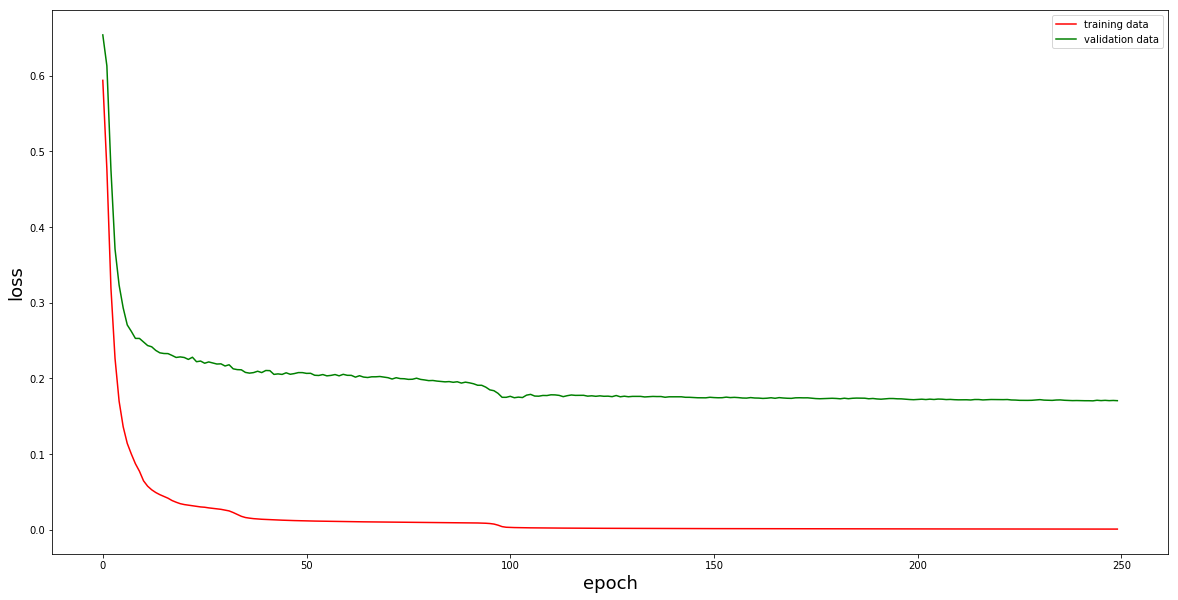

In [29]:
nn1 = NN(X_train.shape[1], 225, 200, n_out=1)

train_losses, val_losses = nn1.fit(X_train, y_train, X_val, y_val, epochs=250, lr=.01, batch_size=32, log=False)

print("nn1 validation accuracy: {:.2f}%".format(nn1.accuracy(X_val, y_val) * 100))
print("nn1 test accuracy: {:.2f}%".format(nn1.accuracy(X_test, y_test) * 100))

nn1.plot(train_losses, val_losses)

### New data formulation for SVM

In [32]:
y = pd.read_pickle('clean_data/y_negpos.pkl')

X_train, X_test, y_train, y_test = train_test_split(x_minmax.values, y.values, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

### Grid search for best SVM parameters

In [33]:
parameters = {'kernel':('rbf', 'poly'), 'C':[.1,1,5,10]}
svm = SVC()
searcher = GridSearchCV(svm, parameters)

searcher.fit(X_train, y_train)
sorted(searcher.cv_results_.keys())

/Users/adamnoack/anaconda/envs/hack/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adamnoack/anaconda/envs/hack/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adamnoack/anaconda/envs/hack/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adamnoack/anaconda/envs/hack/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was 

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [25]:
searcher.cv_results_['param_C']

masked_array(data=[0.1, 0.1, 1, 1, 5, 5, 10, 10],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object)

In [27]:
searcher.cv_results_['param_kernel']

masked_array(data=['rbf', 'poly', 'rbf', 'poly', 'rbf', 'poly', 'rbf',
                   'poly'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object)

In [26]:
searcher.cv_results_['mean_test_score']

array([0.67253521, 0.67253521, 0.67253521, 0.67253521, 0.78873239,
       0.67253521, 0.78521127, 0.67253521])

In [37]:
svm = SVC(C=5, kernel='rbf')
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

/Users/adamnoack/anaconda/envs/hack/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7833333333333333

best params:
    kernel = rbf, C = 5
    kernel = rbf, C = 10

### Run my SVM

In [38]:
svm1 = SVM(n=n_samples, C=1, kernel='rbf')

train_losses, val_losses = svm1.fit(X_train=X_train, y_train=y_train, 
                                        X_val=X_val, y_val=y_val,
                                        tol=.00001, val_acc_break=.82, 
                                        max_epochs=8, log=True)

epoch 0
	train loss: 4.600179
	validation loss: 4.643416
	train accuracy: 32.746479%
	val accuracy: 33.333333%
epoch 1
	train loss: 2.050807
	validation loss: 2.015866
	train accuracy: 52.112676%
	val accuracy: 54.901961%
epoch 2
	train loss: 1.016781
	validation loss: 1.201002
	train accuracy: 80.985915%
	val accuracy: 78.431373%
epoch 3
	train loss: 1.543268
	validation loss: 1.710456
	train accuracy: 66.197183%
	val accuracy: 68.627451%
epoch 4
	train loss: 0.723912
	validation loss: 0.879707
	train accuracy: 92.605634%
	val accuracy: 82.352941%


svm1 validation accuracy: 82.35%


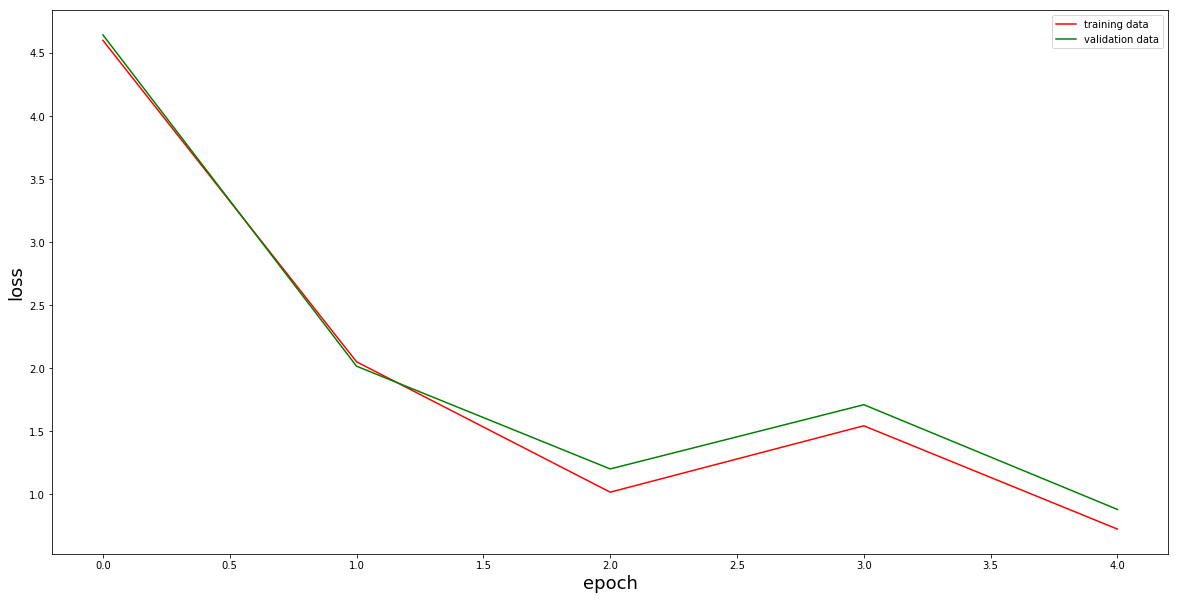

In [39]:
print("svm1 validation accuracy: {:.2f}%".format(svm1.accuracy(X_val, y_val) * 100))
    
svm1.plot(train_losses, val_losses)

In [40]:
print("svm1 test accuracy: {:.2f}%".format(svm1.accuracy(X_test, y_test) * 100))

svm1 test accuracy: 76.67%
